In [9]:
# %%
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import act
import os

# %% Define paths to daily files
daily_files = {
    "NEIU (W08D)": "/Users/bhupendra/projects/crocus/data/cl61/cl61-neiu/crocus-neiu-ceil-a1-20250506-000000.nc",
    "CCICS (W08B)": "/Users/bhupendra/projects/crocus/data/cl61/cl61-ccics/crocus-ccics-ceil-a1-20250506-000000.nc",
    "ATMOS (W09A)": "/Users/bhupendra/projects/crocus/data/cl61/cl61-atmos/crocus-atmos-ceil-a1-20250506-000000.nc",
}

In [10]:

# Helper: Plot cloud heights
def plot_cloud_heights(ax, ds, color='white'):
    if 'sky_condition_cloud_layer_heights_km' not in ds:
        return
    cloud_heights = ds['sky_condition_cloud_layer_heights_km'].values
    times = ds['time'].values

    if len(cloud_heights.shape) == 2:
        times = np.repeat(times, cloud_heights.shape[1])
        heights = cloud_heights.flatten()
    else:
        heights = cloud_heights
        times = np.tile(times, 1)

    mask = ~np.isnan(heights)
    ax.scatter(times[mask], heights[mask], marker=1, c=color, s=5, linewidths=1)


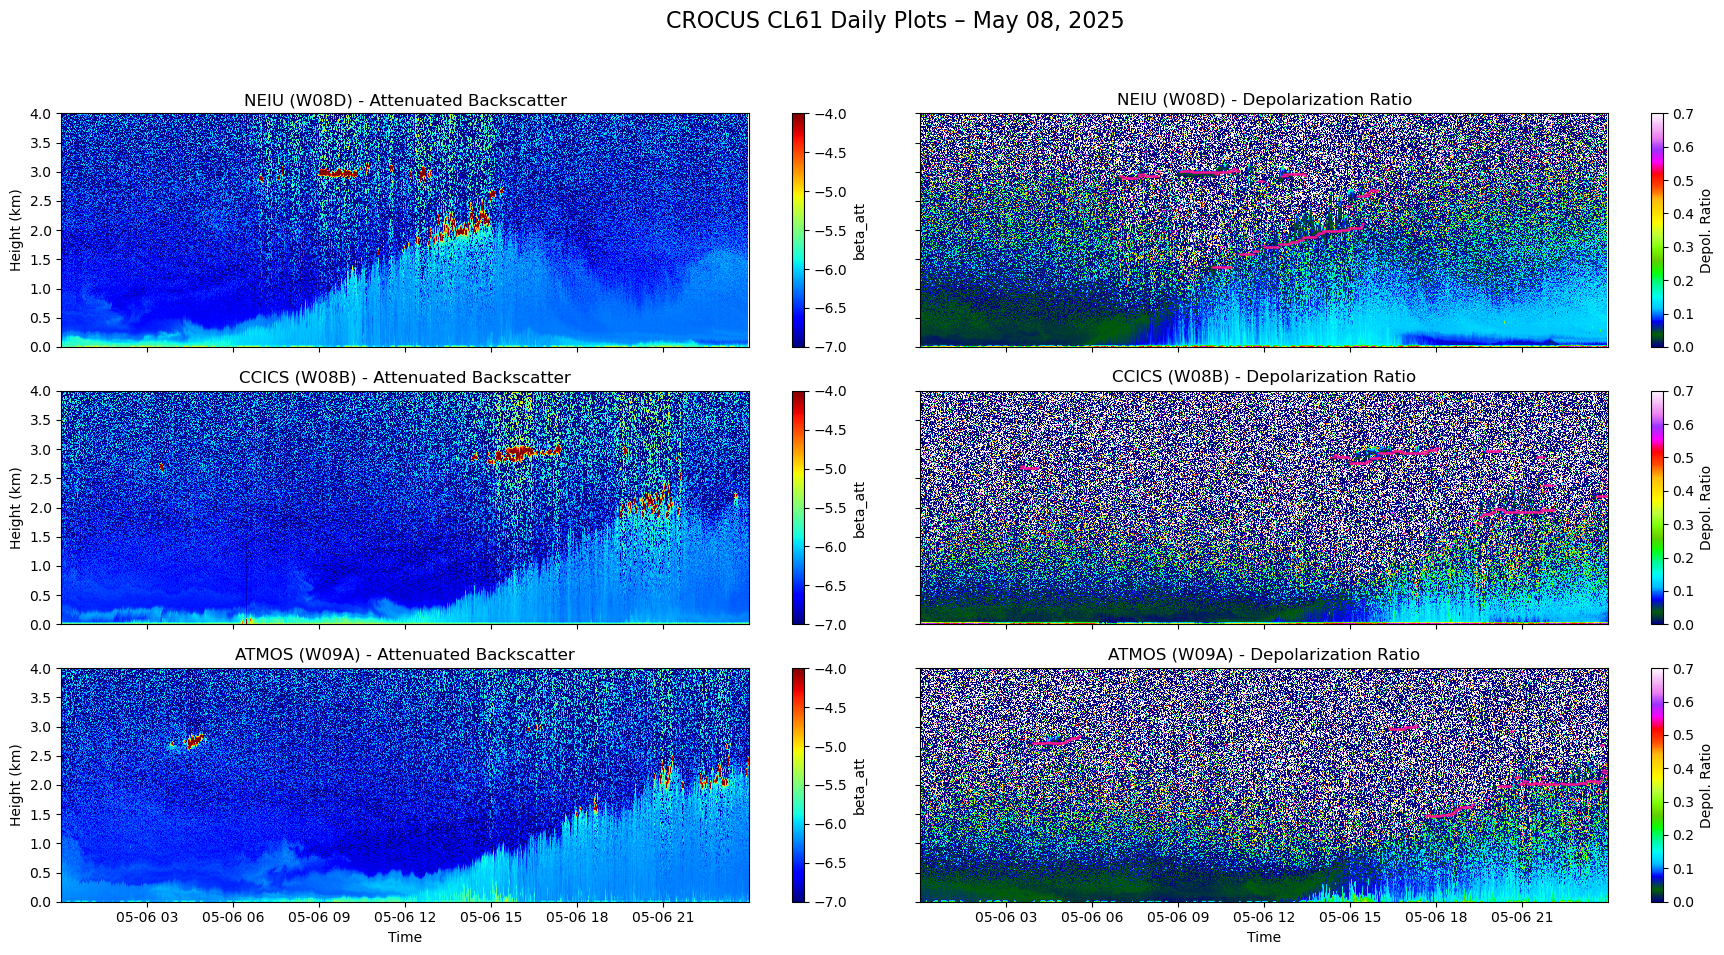

In [11]:

# %% Load and prepare datasets
datasets = {}
for site, filepath in daily_files.items():
    if not os.path.exists(filepath):
        print(f"⚠️ File not found for {site}: {filepath}")
        continue
    ds = xr.open_dataset(filepath)
    for var in ['beta_att', 'p_pol', 'x_pol']:
        if var in ds and var != 'linear_depol_ratio':
            ds = act.corrections.correct_ceil(ds, var_name=var)
    ds = ds.assign(range_km=ds['range'] / 1000)
    ds = ds.assign(sky_condition_cloud_layer_heights_km=ds['sky_condition_cloud_layer_heights'] / 1000)
    ds = ds.swap_dims({'range': 'range_km'})
    datasets[site] = ds

# %% Plot 2-column × 3-row grid
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 10), sharex=True, sharey=True)
ylim = (0, 4)

for i, (site, ds) in enumerate(datasets.items()):
    time = ds['time'].values
    range_km = ds['range_km'].values

    # beta_att (left column)
    beta = ds['beta_att'].values.T
    #vmin_beta, vmax_beta = np.nanpercentile(beta, [2, 98])
    vmin_beta, vmax_beta = -7, -4
    im0 = axes[i][0].pcolormesh(time, range_km, beta, cmap='jet',
                                vmin=vmin_beta, vmax=vmax_beta, shading='auto')
    #plot_cloud_heights(axes[i][0], ds, color='deeppink')
    axes[i][0].set_title(f"{site} - Attenuated Backscatter")
    axes[i][0].set_ylabel("Height (km)")
    axes[i][0].set_ylim(ylim)
    fig.colorbar(im0, ax=axes[i][0], label='beta_att')

    # linear_depol_ratio (right column)
    ldr = ds['linear_depol_ratio'].values.T
    im1 = axes[i][1].pcolormesh(time, range_km, ldr, cmap='gist_ncar',
                                vmin=0, vmax=0.7, shading='auto')
    plot_cloud_heights(axes[i][1], ds, color='deeppink')
    axes[i][1].set_title(f"{site} - Depolarization Ratio")
    axes[i][1].set_ylim(ylim)
    fig.colorbar(im1, ax=axes[i][1], label='Depol. Ratio')

# Final formatting
axes[-1][0].set_xlabel("Time")
axes[-1][1].set_xlabel("Time")
fig.suptitle("CROCUS CL61 Daily Plots – May 08, 2025", fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Second Version NEed testing

In [12]:
# %%
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import act
import os

# %% General helpers
def load_and_correct(files):
    """Load multiple CL61 daily files, apply ACT corrections, convert units to km."""
    ds = xr.open_mfdataset(files, combine='by_coords')
    for var in ['beta_att', 'p_pol', 'x_pol']:
        if var in ds and var != 'linear_depol_ratio':
            ds = act.corrections.correct_ceil(ds, var_name=var)
    ds = ds.assign(range_km=ds['range'] / 1000)
    ds = ds.assign(sky_condition_cloud_layer_heights_km=ds['sky_condition_cloud_layer_heights'] / 1000)
    ds = ds.swap_dims({'range': 'range_km'})
    return ds


In [63]:

def plot_ceilometer_data(datasets, title_suffix, ylim=(0, 3)):
    """Plot β_att and depol ratio stacked in a single column (6 total panels)."""
    nsites = len(datasets)
    nrows = nsites * 2
    fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(12, 3.5 * nrows), sharex=True)
    
    for i, (site, ds) in enumerate(datasets.items()):
        time, z = ds['time'].values, ds['range_km'].values
        beta = ds['beta_att'].values.T
        ldr = ds['linear_depol_ratio'].values.T

        # --- Attenuated backscatter ---
        ax_beta = axes[2 * i]
        im0 = ax_beta.pcolormesh(time, z, beta, cmap='ChaseSpectral', vmin=-7, vmax=-4, shading='auto')
        ax_beta.set_title(f"{site} Attenuated Backscatter")
        ax_beta.set_ylabel("Height [km]")
        ax_beta.set_ylim(ylim)
        fig.colorbar(im0, ax=ax_beta, label=r'$\log_{10}(\beta_{att})$ [1/m·sr]')

        # --- Depolarization ratio ---
        ax_ldr = axes[2 * i + 1]
        im1 = ax_ldr.pcolormesh(time, z, ldr, cmap='nipy_spectral', vmin=0, vmax=0.4, shading='auto')
        ax_ldr.set_title(f"{site} Depolarization Ratio")
        ax_ldr.set_ylabel("Height [km]")
        ax_ldr.set_ylim(ylim)
        fig.colorbar(im1, ax=ax_ldr, label="Depol. Ratio")

    axes[-1].set_xlabel("Time [UTC]")
    fig.suptitle(f"CROCUS CL61 – {title_suffix}", fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()

# %% Define input NetCDF paths (2-day sequence)
base = "/Users/bhupendra/projects/crocus/data/cl61"
file_sets = {
    "NEIU": [f"{base}/cl61-neiu/crocus-neiu-ceil-a1-2025050{i}-000000.nc" for i in [6, 7, 8]],
    "CCICS": [f"{base}/cl61-ccics/crocus-ccics-ceil-a1-2025050{i}-000000.nc" for i in [6, 7, 8]],
    "ATMOS": [f"{base}/cl61-atmos/crocus-atmos-ceil-a1-2025050{i}-000000.nc" for i in [6, 7, 8]],
}


# Remove nide name
# 

In [75]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

def plot_ceilometer_data_2col(datasets, title_suffix, ylim=(0, 3)):
    """Plot β_att and depol ratio in a 2-column grid with shared colorbars."""
    nsites = len(datasets)
    fig, axes = plt.subplots(
        nrows=nsites, ncols=2, figsize=(18, 3.5 * nsites),
        sharex=True, sharey=True, constrained_layout=True
    )
    
    # Ensure axes is always 2D even for 1 site
    if nsites == 1:
        axes = np.array([axes])

    for i, (site, ds) in enumerate(datasets.items()):
        time = ds['time'].values
        z = ds['range_km'].values
        beta = ds['beta_att'].values.T
        ldr = ds['linear_depol_ratio'].values.T

        # --- Left: Backscatter ---
        ax_beta = axes[i, 0]
        im0 = ax_beta.pcolormesh(
            time, z, beta, cmap='ChaseSpectral',
            vmin=-7, vmax=-4, shading='auto'
        )
        ax_beta.set_title(f"{site}", fontsize=14)
        ax_beta.set_ylabel("Height [km]", fontsize=17)
        ax_beta.set_ylim(ylim)

        ax_beta.set_yticks([0, 1, 2, 3])
        ax_beta.tick_params(axis='both', labelsize=13)

        # --- Right: Depolarization Ratio ---
        ax_ldr = axes[i, 1]
        im1 = ax_ldr.pcolormesh(
            time, z, ldr, cmap='nipy_spectral',
            vmin=0, vmax=0.4, shading='auto'
        )
        ax_ldr.set_title(f"{site}", fontsize=14)
        ax_ldr.set_ylim(ylim)

        ax_ldr.set_yticks([0, 1, 2, 3])
        ax_ldr.tick_params(axis='both', labelsize=13)

    # Format x-axis only for the bottom row
    for ax in axes[-1]:
        ax.set_xlabel("Time [UTC]", fontsize=17)
        ax.tick_params(axis='x', labelsize=13)

        # Format datetime ticks: 'May 06 12:00'
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d %H:%M'))
        for label in ax.get_xticklabels():
            label.set_rotation(30)
            label.set_horizontalalignment('right')

    # Shared colorbars below each column
    cbar_beta = fig.colorbar(im0, ax=axes[:, 0], orientation='horizontal', fraction=0.03, pad=0.03)
    cbar_beta.set_label(r'$\log_{10}(\beta_{att})$ [1/m·sr]', fontsize=17)
    cbar_beta.ax.tick_params(labelsize=13)

    cbar_beta.set_label(r'$\log_{10}(\beta_{att})$ [1/m·sr]', fontsize=17)
    cbar_beta.ax.tick_params(labelsize=13)

    cbar_ldr = fig.colorbar(im1, ax=axes[:, 1], orientation='horizontal', fraction=0.03, pad=0.03)
    cbar_ldr.set_label("Depolarization Ratio", fontsize=17)
    cbar_ldr.ax.tick_params(labelsize=13)
    cbar_ldr.set_label("Depolarization Ratio", fontsize=17)
    cbar_ldr.ax.tick_params(labelsize=13)

    #fig.suptitle(f"CROCUS CL61 – {title_suffix}", fontsize=18)

    plt.show()


In [76]:

# %% Load and plot
datasets = {site: load_and_correct(files) for site, files in file_sets.items() if all(os.path.exists(f) for f in files)}

from datetime import timedelta

# Shift time for NEIU
if "NEIU" in datasets:
    datasets["NEIU"] = datasets["NEIU"].assign_coords(
        time=datasets["NEIU"]["time"] + np.timedelta64(6, 'h')
    )

# Define your time range (as strings or np.datetime64)
start_time = np.datetime64("2025-05-06T06:00")
end_time = np.datetime64("2025-05-08T06:00")

# Slice each dataset to the desired time range
for site in datasets:
    datasets[site] = datasets[site].sel(time=slice(start_time, end_time))



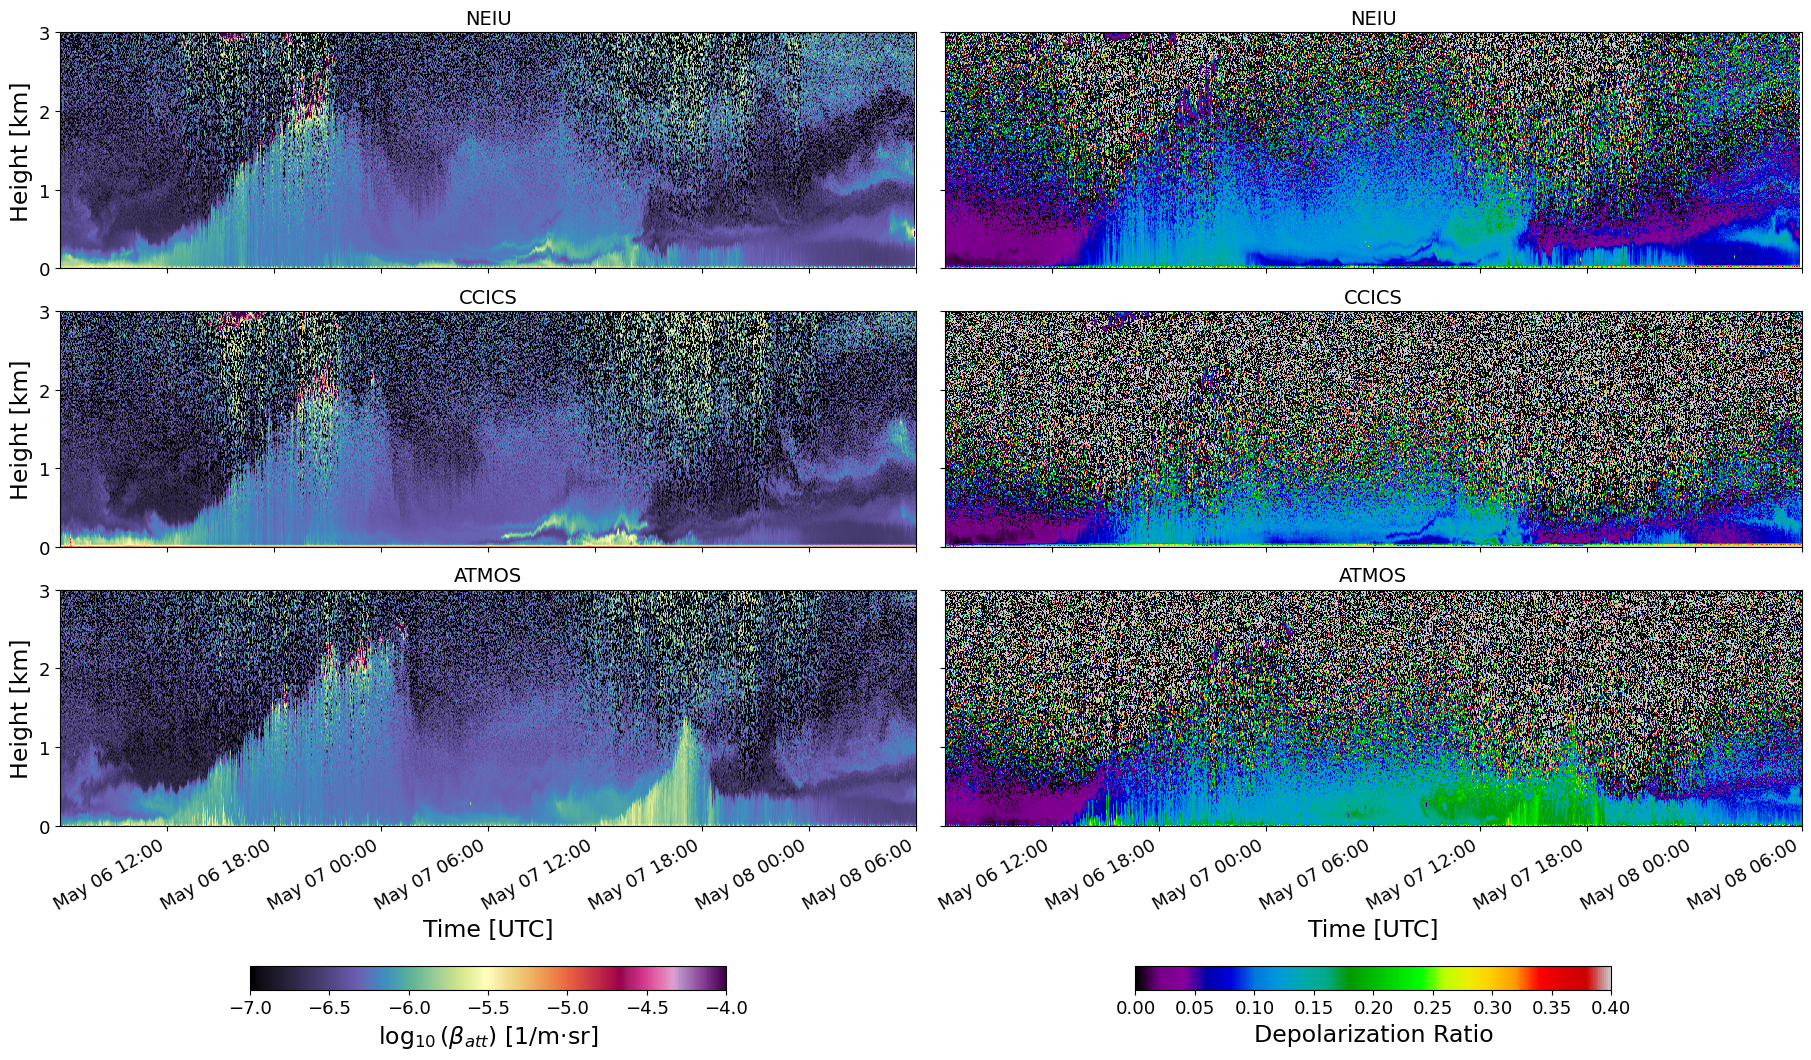

In [78]:
plot_ceilometer_data_2col(datasets, "May 6–8 2025")
fig.savefig(f"cl61_micronet.pdf", format='pdf', bbox_inches='tight')


In [15]:
ds


<xarray.Dataset> Size: 95MB
Dimensions:                               (time: 1438, layer: 5, range_km: 3276)
Coordinates:
  * time                                  (time) datetime64[ns] 12kB 2025-05-...
    range                                 (range_km) float64 26kB 0.0 ... 1.5...
  * layer                                 (layer) float64 40B 1.0 2.0 ... 5.0
    longitude                             float64 8B ...
    latitude                              float64 8B ...
  * range_km                              (range_km) float64 26kB 0.0 ... 15.72
Data variables: (12/27)
    cloud_base_heights                    (time, layer) float64 58kB ...
    vertical_visibility                   (time) float64 12kB ...
    p_pol                                 (time, range_km) float32 19MB -6.13...
    x_pol                                 (time, range_km) float32 19MB -7.36...
    beta_att                              (time, range_km) float32 19MB -6.10...
    linear_depol_ratio                    (time, range_km) float32 19MB 0.058...
    ...                                    ...
    receiver_gain                         (time) float32 6kB ...
    range_resolution                      (time) float32 6kB ...
    cloud_calibration_factor              (time) float64 12kB ...
    cloud_calibration_factor_user         (time) float64 12kB ...
    overlap_function                      (time, range_km) float32 19MB ...
    sky_condition_cloud_layer_heights_km  (time, layer) float64 58kB nan ... nan
Attributes: (12/30)
    title:                          CL61D CL61 with Depolarization
    institution:                    Argonne National Laboratory
    source:                         CROCUS Measurement Strategy
    conventions:                    CF-1.8
    schema_version:                 1.3
    sw_version:                     1.2.7
    ...                             ...
    funding_source:                 U.S. DOE Office of Science, Biological an...
    acknowledgment:                 This material is based upon work supporte...
    data_version:                   v1.1.0
    file_version:                   
    doi:                            
    file_creation_date:             2025-10-30